In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

In [2]:
device = "cuda"

# Load the pretrained DDPM pipeline on the CelebA-HQ dataset and move it to the specified device
# Generate an image from the model

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\swtir\.cache\huggingface\hub\models--google--ddpm-celebahq-256\snapshots\cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\swtir\.cache\huggingface\hub\models--google--ddpm-celebahq-256\snapshots\cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

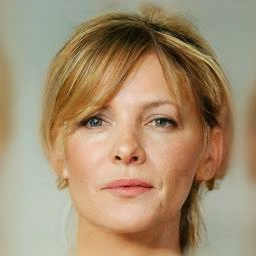

In [3]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)
images = image_pipe().images
images[0]

# Initialize DDIMScheduler for faster inference with 40 denoising steps
# Set a batch of random starting images of shape (4, 3, 256, 256) as input

# Perform denoising steps using the scheduler
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Scale model input based on the current timestep
    # Predict noise to remove from the current image using the UNet model

    # Compute the updated image sample after denoising at the current timestep
    # Update the input image for the next iteration

    # Display the intermediate images every 10 steps and at the final step
    # Show the noisy input x and the predicted denoised images


0it [00:00, ?it/s]

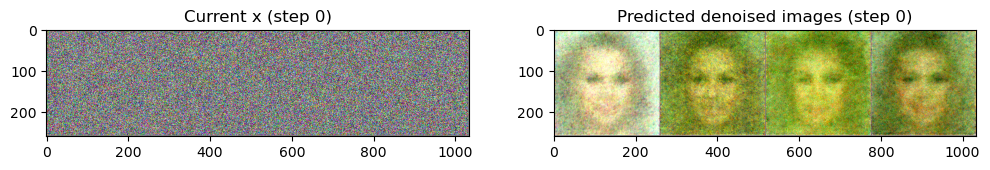

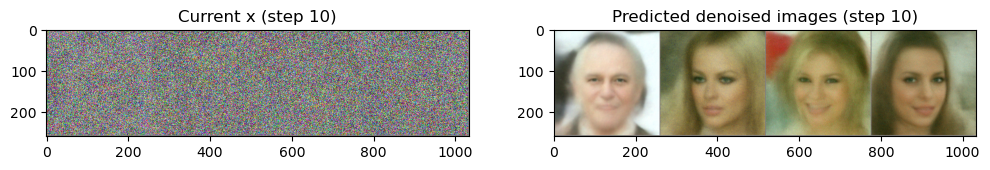

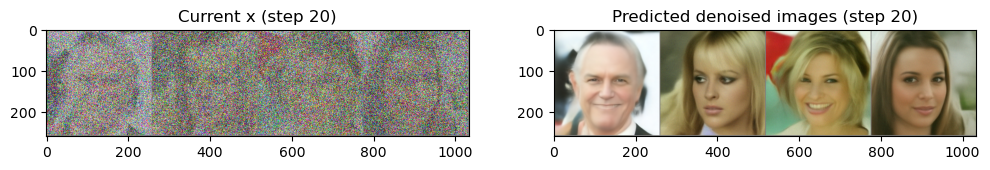

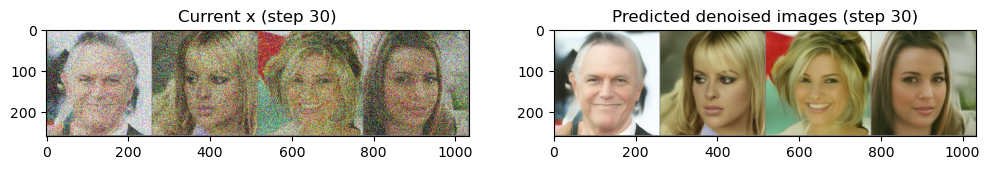

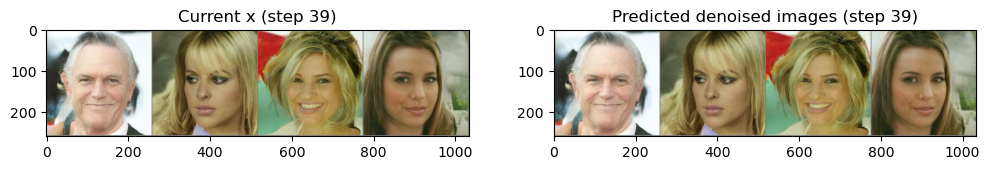

In [4]:
# Create new scheduler and set num inference steps
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)
# The random starting point
x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256 x 256 px images

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare model input
    model_input = scheduler.scale_model_input(x, t)

    # Get the prediction
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Calculate what the updated sample should look like with the scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    # Update x
    x = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = scheduler_output.pred_original_sample  # Not available for all schedulers
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

# Assign new scheduler (DDIMScheduler) to pipeline
# Generate images with updated scheduler using 40 inference steps

  0%|          | 0/40 [00:00<?, ?it/s]

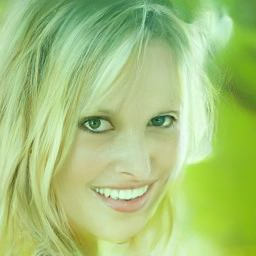

In [5]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

 Load and prepare the butterfly dataset from the "huggan/smithsonian_butterflies_subset" collection
 
 Define image transformations: resize, flip, convert to tensor, and normalize for model compatibility
 
 Set transformation function and apply it to the dataset
 
 Create a DataLoader for batching and shuffling images during training
 
 a preview batch of images to confirm data loading and transformations

README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

C:\Users\swtir\anaconda3\envs\dml\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\swtir\.cache\huggingface\hub\datasets--huggan--smithsonian_butterflies_subset. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Previewing batch:


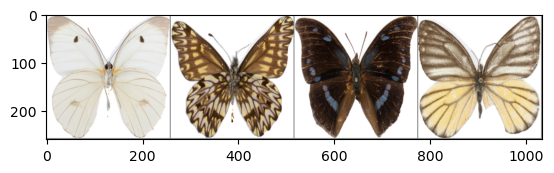

In [6]:
dataset_name = "huggan/smithsonian_butterflies_subset"  # @param
dataset = load_dataset(dataset_name, split="train")
image_size = 256  # @param
batch_size = 4  # @param
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

 Training parameters: define number of epochs, learning rate, and gradient accumulation steps
 Initialize the AdamW optimizer for UNet model parameters with specified learning rate
 Initialize an empty list to track loss values during training
 Begin training loop over defined epochs
   - Loop through each batch in the DataLoader
   - Add noise to clean images as part of the forward diffusion process
   - Generate predictions with the UNet model and compute loss against actual noise
   - Backpropagate the loss and accumulate gradients based on defined steps
   - Update optimizer parameters and reset gradients at each accumulation step
 Display average loss per epoch and plot the loss curve to track training progress

  0%|          | 0/250 [00:00<?, ?it/s]

C:\Users\swtir\anaconda3\envs\dml\Lib\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0 average loss: 0.013629775496083312


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 average loss: 0.012767565244343132


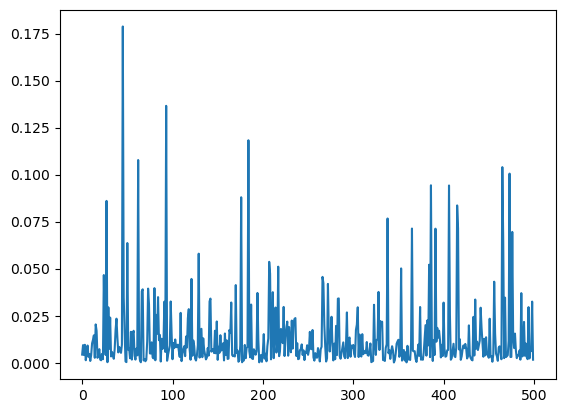

In [7]:
num_epochs = 2  
lr = 1e-5  
grad_accumulation_steps = 2  

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}")

# Plot the loss curve:
plt.plot(losses)

# Generate and visualize images:
 - Initialize a batch of random noise tensors to act as the starting point for image generation.
 - Iterate over each timestep in the scheduler:
   - Scale model input based on the current timestep.
   - Perform a forward pass with UNet to predict noise.
   - Use the scheduler to step back and refine the generated image.
 - Arrange and display the generated images in a grid format, showing the results of the denoising process.

0it [00:00, ?it/s]

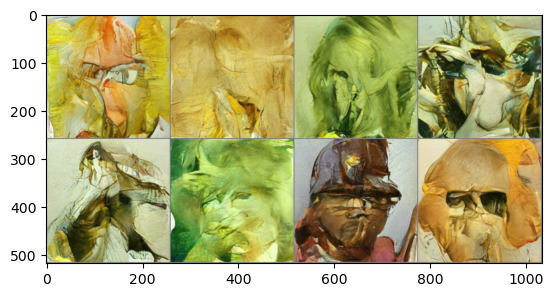

In [8]:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

In [9]:
image_pipe.save_pretrained("my-finetuned-model")

For the rest of this notebook we'll use a [model](https://huggingface.co/johnowhitaker/sd-class-wikiart-from-bedrooms) fine-tuned from [this model trained on LSUN bedrooms](https://huggingface.co/google/ddpm-bedroom-256) approximately one epoch on the [WikiArt dataset](https://huggingface.co/datasets/huggan/wikiart). If you'd prefer, you can skip this cell and use the faces/butterflies pipeline we fine-tuned in the previous section or load one from the Hub instead:


# Load and sample images from a pretrained diffusion pipeline:
 - Load a pretrained DDPMPipeline using a specific model ("sd-class-wikiart-from-bedrooms") and move it to the device.
 - Initialize a DDIM Scheduler with 40 inference steps for efficient image generation.
 - Set up a batch of random noise as the starting point.
 - For each timestep in the scheduler:
   - Adjust the model input based on the current timestep.
   - Use the UNet to predict noise and refine the generated image iteratively.
 - Display the final generated images in a grid to visualize the model output.

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

C:\Users\swtir\anaconda3\envs\dml\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\swtir\.cache\huggingface\hub\models--johnowhitaker--sd-class-wikiart-from-bedrooms. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/938 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

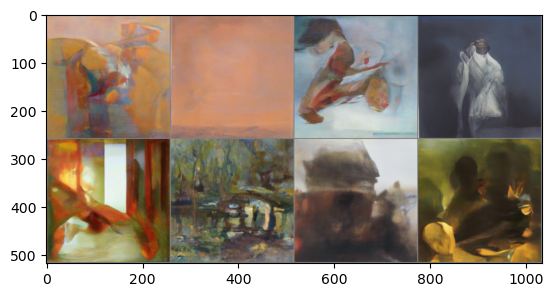

In [11]:
# Load the pretrained pipeline
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

# Sample some images with a DDIM Scheduler over 40 steps
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

# Random starting point (batch of 8 images)
x = torch.randn(8, 3, 256, 256).to(device)

# Minimal sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the results
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

# Define a custom color loss function:
 - `color_loss` -> how closely an image's colors match a specified target color.
 - The target color defaults to a light teal (R: 0.1, G: 0.9, B: 0.5) but can be modified as needed.
 - Target color is scaled to the range (-1, 1), matching the normalized pixel range of the input images.
 - Computes the mean absolute error between each pixel and the target color across all channels.
 - Returns an average error value, which is used to guide generated images toward the target color.

In [12]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    """Given a target color (R, G, B) return a loss for how far away on average
    the images' pixels are from that color. Defaults to a light teal: (0.1, 0.9, 0.5)"""
    target = torch.tensor(target_color).to(images.device) * 2 - 1  # Map target color to (-1, 1)
    target = target[None, :, None, None]  # Get shape right to work with the images (b, c, h, w)
    error = torch.abs(images - target).mean()  # Mean absolute difference between the image pixels and the target color
    return error

# Implementing Gradient-Guided Generation with Color Loss
 
 - **Guidance Scale Setup**: Sets the `guidance_loss_scale` to control the strength of the color guidance.
 - **Latent Initialization**: Initializes the latent tensor `x` with random noise, preparing for generation.
 - **Denoising Loop with Gradient Guidance**:
     - Enables gradient tracking on `x` to allow backpropagation for the color guidance.
     - Scales `x` with the scheduler to align with the current timestep (`t`).
     - Predicts noise using the UNet model and computes `x0`, a denoised estimate.
     - Calculates the `color_loss` between `x0` and the target color, scaled by `guidance_loss_scale`.
     - Periodically outputs the loss value for tracking.
     - Computes the gradient of the loss relative to `x`, and adjusts `x` by a small amount in the direction opposite to the gradient (`cond_grad`).
     - Steps the scheduler forward to update `x` for the next iteration.
 
# - **Final Image Conversion**:
     - Converts the denoised and guided latent `x` into an image using `make_grid`.
     - Scales and converts the result to a displayable PIL image.


0it [00:00, ?it/s]

0 loss: 30.435016632080078
10 loss: 22.62031364440918
20 loss: 21.95908546447754
30 loss: 22.133054733276367


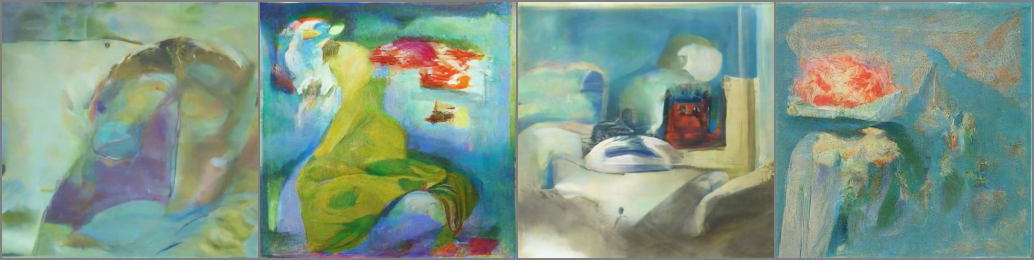

In [13]:
# Variant 2: setting x.requires_grad before calculating the model predictions

guidance_loss_scale = 40
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Set requires_grad before the model forward pass
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)

    # predict (with grad this time)
    noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Get the predicted x0:
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

***Loading and Using CLIP for Text-Based Guidance***

Load  CLIP model (ViT-B-32) from OpenAI. CLIP is used for encoding both images and text so that they can be compared in the same embedding space.
 
This loop applies CLIP-based text guidance to steer the generated images to match the text prompt ("Red Rose"). The guidance gradient influences x to align with the CLIP embedding of the prompt. at the end, displays the final results after text-guided diffusion

then, Define transformations for augmenting and normalizing images before passing them to CLIP for encoding

***Defining the CLIP-Based Loss Function***

This function computes the distance between the image and text features using CLIP. It measures how well the image matches the text prompt by calculating the "Great Circle Distance" between their normalized embeddings

In [14]:
# @markdown load a CLIP model and define the loss function
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
clip_model.to(device)

# Transforms to resize and augment an image + normalize to match CLIP's training data
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),  # Random CROP each time
        torchvision.transforms.RandomAffine(5),  # One possible random augmentation: skews the image
        torchvision.transforms.RandomHorizontalFlip(),  # You can add additional augmentations if you like
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)


# And define a loss function that takes an image, embeds it and compares with
# the text features of the prompt
def clip_loss(image, text_features):
    image_features = clip_model.encode_image(tfms(image))  # Note: applies the above transforms
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)  # Squared Great Circle Distance
    return dists.mean()

***Applying CLIP Guidance to Steer Generation***

Tokenize and encode the text prompt using CLIP. The guidance_scale and n_cuts control the influence and number of cutouts for averaging the CLIP loss

then,  loop applies CLIP-based text guidance to steer the generated images to match the text prompt ("Red Rose"). The guidance gradient influences x to align with the CLIP embedding of the prompt, and displays the final results after text-guided diffusion

C:\Users\swtir\AppData\Local\Temp\ipykernel_13408\147393755.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


0it [00:00, ?it/s]

Step: 0 , Guidance loss: 7.472652435302734
Step: 25 , Guidance loss: 7.117615699768066


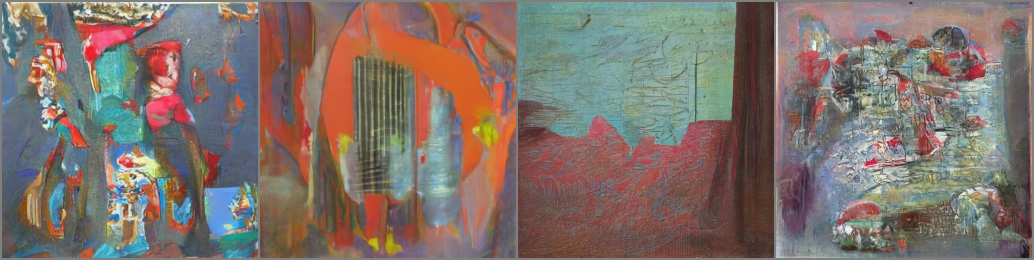

In [15]:
# @markdown applying guidance using CLIP

prompt = "Red Rose (still life), red flower painting"  # @param

# Explore changing this
guidance_scale = 8  # @param
n_cuts = 4  # @param

# More steps -> more time for the guidance to have an effect
scheduler.set_timesteps(50)

# We embed a prompt with CLIP as our target
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)


x = torch.randn(4, 3, 256, 256).to(device)  # RAM usage is high, you may want only 1 image at a time

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        # Set requires grad on x
        x = x.detach().requires_grad_()

        # Get the predicted x0:
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        # Calculate loss
        loss = clip_loss(x0, text_features) * guidance_scale

        # Get gradient (scale by n_cuts since we want the average)
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modify x based on this gradient
    alpha_bar = scheduler.alphas_cumprod[i]
    x = x.detach() + cond_grad * alpha_bar.sqrt()  # Note the additional scaling factor here!

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

***Visualize different possible scaling schedules for applying the guidance gradient:***

Text(0.5, 1.0, 'Possible guidance scaling schedules')

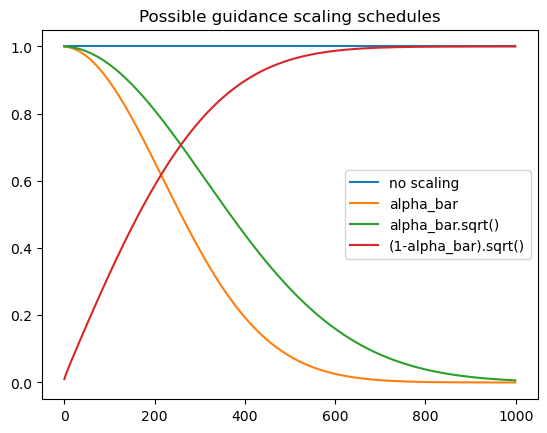

In [16]:
# @markdown Plotting some possible schedules:
plt.plot([1 for a in scheduler.alphas_cumprod], label="no scaling")
plt.plot([a for a in scheduler.alphas_cumprod], label="alpha_bar")
plt.plot([a.sqrt() for a in scheduler.alphas_cumprod], label="alpha_bar.sqrt()")
plt.plot([(1 - a).sqrt() for a in scheduler.alphas_cumprod], label="(1-alpha_bar).sqrt()")
plt.legend()
plt.title("Possible guidance scaling schedules")